**GOAL: Check Duncan Campbell's redshift-space correlation function calculation for MDR1 FoF halos**

# Loading modules

In [2]:
%matplotlib inline
import getpass
import h5py
import math
import numpy as np
import os
import pickle
import pyfits
import socket
import sys
import time

#require CosmoloPy
import cosmolopy.distance as cd
from scipy import integrate, interpolate

if getpass.getuser()=='ssaito':
    HOMEDIR = '/Users/ssaito/'
    DIRNAME = '/Volumes/Transcend/CosmoTreasure/sim/multidark/MDR1/'
elif getpass.getuser()=='shsaito':
    HOMEDIR = '/Users/shsaito/'
    #DIRNAME = '/Volumes/MyBookThunderboltDuo/CosmoTreasure/mock/cosmos/'
    
##CONSTANTS
SQDEGtoSTR = math.pi**2./32400
Mpctocm = 3.0857E+24

## Plot
import matplotlib.pyplot as plt
from matplotlib import ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from ss_default_plot import *

## reading halo catalog

In [4]:
#MDR1 simulation, see https://www.cosmosim.org/cms/simulations/mdr1/
CP = {'omega_M_0':0.27, 'omega_lambda_0':0.73, 'omega_k_0':0.0, 'h':0.70}
a_scale = 1.
z_red = 1./a_scale - 1.
KMpSECtoMPCpH = 1./a_scale/100./cd.e_z(z_red, **CP)
Lbox = 1000.

In [11]:
from astropy.table import Table
fname = DIRNAME+"mdr1_fof_va.hdf5"
t = Table.read(fname, path='data')

In [24]:
print(t.keys())
print(t['x'].shape)

['vy', 'vx', 'mass', 'rowid', 'haloid', 'y', 'x', 'vz', 'z', 'size', 'vx_central_ptcl', 'vx_inner01', 'vx_inner10', 'vx_inner20', 'vx_inner30', 'vx_inner40', 'vx_inner50', 'vx_inner60', 'vx_inner70', 'vx_inner80', 'vx_inner90', 'vx_all', 'vx_std', 'vy_central_ptcl', 'vy_inner01', 'vy_inner10', 'vy_inner20', 'vy_inner30', 'vy_inner40', 'vy_inner50', 'vy_inner60', 'vy_inner70', 'vy_inner80', 'vy_inner90', 'vy_all', 'vy_std', 'vz_central_ptcl', 'vz_inner01', 'vz_inner10', 'vz_inner20', 'vz_inner30', 'vz_inner40', 'vz_inner50', 'vz_inner60', 'vz_inner70', 'vz_inner80', 'vz_inner90', 'vz_all', 'vz_std']
(370679,)


In [25]:
for i in xrange(20):
    print t['vz'][i], t['vz_all'][i]

87.5100021362 87.5112535589
458.660003662 458.663684454
-116.379997253 -116.378511674
-0.289999991655 -0.285735007074
-354.029998779 -354.027035622
116.059997559 116.056635734
-306.799987793 -306.802330178
80.6200027466 80.6220362433
-155.440002441 -155.440809244
-253.100006104 -253.095492476
474.559997559 474.564665412
20.3700008392 20.3656310727
259.779998779 259.779738032
-240.679992676 -240.681855414
-117.959999084 -117.955219403
-48.8800010681 -48.882545978
68.2200012207 68.2249726995
58.2000007629 58.2016608583
4.51000022888 4.51292723621
135.520004272 135.516954572


In [26]:
## prepare (x,y,z) ascii file
arr_pos = np.zeros(shape=(370679, 3), dtype=np.float)
# x
arr_pos[:,0] = t['x'][:]
# y
arr_pos[:,1] = t['y'][:]
# z
arr_pos[:,2] = t['z'][:] + t['vz'][:]*KMpSECtoMPCpH
# save
np.savetxt(DIRNAME+'pos_zspace_MDR1-FoF_vbulk.dat', arr_pos)

# z
arr_pos[:,2] = 0.
arr_pos[:,2] = t['z'][:] + t['vz_inner10'][:]*KMpSECtoMPCpH
# save
np.savetxt(DIRNAME+'pos_zspace_MDR1-FoF_vinner10.dat', arr_pos)

In [28]:
def make_random(num_random, fname_out, 
                Lmin = np.array([0., 0., 0.]), 
                Lmax = np.array([100., 100., 100.])):
    random_seeds = np.random.rand(num_random, 3)
    arr_rand = np.zeros(shape=(num_random,3), dtype=np.float)
    for i in xrange(3):
        arr_rand[:,i] = Lmin[i] + random_seeds[:,i]*(Lmax[i]-Lmin[i])
    np.savetxt(fname_out, arr_rand, fmt='%8.5f %8.5f %8.5f')
    return

make_random(int(5e6), DIRNAME+'randlist_L1000.dat', Lmax = np.array([1000., 1000., 1000.]))

# Plot multipole

In [46]:
xiell_vbulk = np.loadtxt(DIRNAME+'xiell.zspace_MDR1-FoF_vbulk.dat')
xiell_vinner10 = np.loadtxt(DIRNAME+'xiell.zspace_MDR1-FoF_vinner10.dat')
xiell_vin10_Duncan = np.loadtxt(DIRNAME+'Duncan_multipoles_vz_inner10.dat')

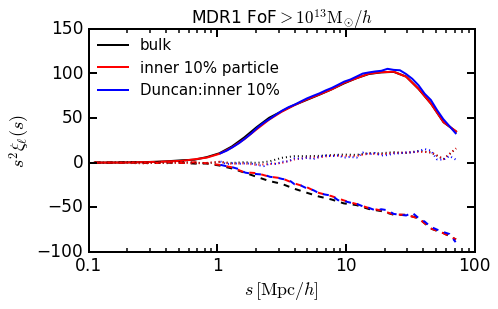

In [47]:
fig_width_pt = 510                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.1,100.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(-10.,15.)
#ax.set_ylim(1.2,1.8)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$s^{2}\xi_{\ell}(s)$', fontsize=18)
ax.set_title(r'MDR1 FoF$>10^{13}{\rm M_{\odot}}/h$', fontsize=17)
#ax.hlines(y=1., xmin=1.E-18, xmax=1.E-15)
#ax.text(0.4, 1000., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(xiell_vbulk[:,0], xiell_vbulk[:,0]**2.*xiell_vbulk[:,1], 'k-', lw=2, label='bulk')
ax.plot(xiell_vinner10[:,0], xiell_vbulk[:,0]**2.*xiell_vinner10[:,1], 'r-', lw=2, label='inner 10% particle')
ax.plot(xiell_vin10_Duncan[:,0], xiell_vin10_Duncan[:,0]**2.*xiell_vin10_Duncan[:,1], 'b-', lw=2, label='Duncan:inner 10%')


ax.plot(xiell_vbulk[:,0], xiell_vbulk[:,0]**2.*xiell_vbulk[:,2], 'k--', lw=2)
ax.plot(xiell_vinner10[:,0], xiell_vbulk[:,0]**2.*xiell_vinner10[:,2], 'r--', lw=2)
ax.plot(xiell_vin10_Duncan[:,0], xiell_vin10_Duncan[:,0]**2.*xiell_vin10_Duncan[:,2], 'b--', lw=2)

ax.plot(xiell_vbulk[:,0], xiell_vbulk[:,0]**2.*xiell_vbulk[:,3], 'k:', lw=2)
ax.plot(xiell_vinner10[:,0], xiell_vbulk[:,0]**2.*xiell_vinner10[:,3], 'r:', lw=2)
ax.plot(xiell_vin10_Duncan[:,0], xiell_vin10_Duncan[:,0]**2.*xiell_vin10_Duncan[:,3], 'b:', lw=2)


axleg = ax.legend(loc='upper left', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/xiell_MDR1_FoF_z0.png')
plt.show()

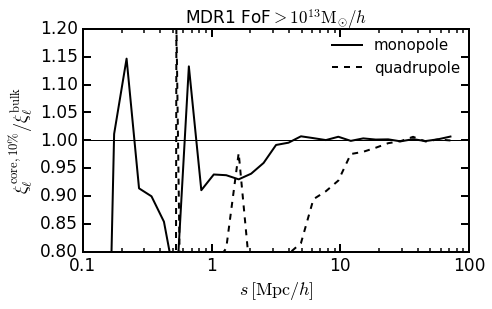

In [44]:
fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
ax.set_xscale('log')
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(0.1,100.)
#ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#ax.set_ylim(-10.,15.)
ax.set_ylim(0.8,1.2)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='minor', length=4, width=1.5)
ax.tick_params(which='major', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
## Axis label
ax.set_xlabel(r'$s\,[{\rm Mpc}/h]$', fontsize=18)
ax.set_ylabel(r'$\xi^{\rm core, 10\%}_{\ell}/\xi^{\rm bulk}_{\ell}$', fontsize=18)
ax.set_title(r'MDR1 FoF$>10^{13}{\rm M_{\odot}}/h$', fontsize=17)
ax.hlines(y=1., xmin=0.1, xmax=100.)
#ax.text(0.4, 1000., r'$M^{\rm host}_{\rm vir}>10^{13.5}$', fontsize=16)

ax.plot(xiell_vbulk[:,0], xiell_vinner10[:,1]/xiell_vbulk[:,1], 'k-', lw=2, label='monopole')
ax.plot(xiell_vinner10[:,0], xiell_vinner10[:,2]/xiell_vbulk[:,2], 'k--', lw=2, label='quadrupole')


axleg = ax.legend(loc='upper right', numpoints=1, 
                  ncol=1, fontsize=15, borderaxespad=0.2)
axleg.draw_frame(False)

plt.savefig(HOMEDIR+'Desktop/frac_xiell_FoF_MDR1_z0.png')
plt.show()